# StarGunner - Reinforcement Learning

## Configurações Iniciais

In [3]:
!pip install pygame
!pip install moviepy
!pip install torch
!pip install opencv-python
!pip install swig
!pip install gymnasium[all]
!pip install gymnasium[atari,accept-rom-license]
!pip install "stable-baselines3[extra]==2.1.0"
!pip install gymnasium[box2d]
!pip install tensorboard

import pygame # this import here is just to prevent a strange bug (with some dynamic library used by pygame and other packages)
import sys
from IPython.display import clear_output
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

!git clone https://github.com/pablo-sampaio/rl_facil
sys.path.append("/content/rl_facil")

clear_output()


Import para o CUDA funcionar

In [4]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [5]:
import time
from datetime import datetime
import collections
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import tensorboard
import stable_baselines3
stable_baselines3.__version__
import matplotlib.pyplot as plt
import gymnasium as gym
from utils import dqn_models
from utils.atari_wrappers import *

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.ppo import CnnPolicy

from utils.notebook import (
    display_videos_from_path,
    display_videos_from_path_widgets,
    display_video,
)

Para treinar usando a GPU

In [6]:
# usar GPU compatível com CUDA costuma ser mais rápido
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.set_default_device(device)

torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

Carrega a extensão para visualizar o `tensorboard`

In [7]:
%load_ext tensorboard

## Funções para gerar gráficos

Gráfico de resultados individuais, com desvio padrão e distribuição normal

In [9]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

def extract_scalar_from_event(file_path, scalar_name):
    event_acc = EventAccumulator(file_path, size_guidance={'scalar': 0})
    event_acc.Reload()

    steps = [scalar.step for scalar in event_acc.Scalars(scalar_name)]
    values = [scalar.value for scalar in event_acc.Scalars(scalar_name)]

    return steps, values

def get_last_values(folder_path, scalar_name='rollout/ep_rew_mean'):
    last_values = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith("events"):  
            file_path = os.path.join(folder_path, file_name)
            steps, values = extract_scalar_from_event(file_path, scalar_name)
            if values:
                last_values.append(values[-1])

    return last_values

def plot_distribution_of_last_values(log_directory, scalar_name='rollout/ep_rew_mean'):
    last_values = []

    for subdirectory in os.listdir(log_directory):
        subdirectory_path = os.path.join(log_directory, subdirectory)
        if os.path.isdir(subdirectory_path):
            last_values.extend(get_last_values(subdirectory_path, scalar_name))

    # Plotando a distribuição normal para os últimos valores de cada arquivo
    plt.figure(figsize=(16, 9))
    sns.histplot(last_values, kde=True, label='Distribution', stat='density')
    plt.title(f'Distribution of Last {scalar_name} Values for All Files')
    plt.xlabel(f'Last {scalar_name} Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def process_folder(folder_path, scalar_name='rollout/ep_rew_mean'):
    all_steps = []
    all_values = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith("events"):  
            file_path = os.path.join(folder_path, file_name)
            steps, values = extract_scalar_from_event(file_path, scalar_name)
            all_steps.append(steps)
            all_values.append(values)

    return all_steps, all_values

def process_folder_individual(folder_path, scalar_name='rollout/ep_rew_mean'):
    all_steps = []
    all_values = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith("events"):  # Certifique-se de que é um arquivo de eventos TensorBoard
            file_path = os.path.join(folder_path, file_name)
            steps, values = extract_scalar_from_event(file_path, scalar_name)
            all_steps.extend(steps)
            all_values.extend(values)

    return all_steps, all_values

def plot_individual(log_directories, scalar_name='rollout/ep_rew_mean'):
    plt.figure(figsize=(16,9))
    for log_directory in log_directories:
        for subdirectory in os.listdir(log_directory):
            subdirectory_path = os.path.join(log_directory, subdirectory)
            if os.path.isdir(subdirectory_path):
                steps, values = process_folder_individual(subdirectory_path, scalar_name)
                
                # Plotando os resultados individuais
                plt.plot(steps, values, label=f'{subdirectory}')

    plt.xlabel('Steps')
    plt.ylabel(f'Reward')
    plt.legend()
    plt.title(f'Reward x Step')
    plt.show()

def plot_individual_and_mean_with_std_and_distribution(log_directory, scalar_name='rollout/ep_rew_mean'):
    all_steps = []
    all_values = []

    # Plotando as linhas individuais e calculando a média e desvio padrão
    for subdirectory in os.listdir(log_directory):
        subdirectory_path = os.path.join(log_directory, subdirectory)
        if os.path.isdir(subdirectory_path):
            steps, values = process_folder(subdirectory_path, scalar_name)

            all_steps.extend(steps)
            all_values.extend(values)

    flat_all_steps = [item for sublist in all_steps for item in sublist]
    flat_all_values = [item for sublist in all_values for item in sublist]

    unique_steps = sorted(set(flat_all_steps))
    interp_values = []
    
    for steps, values in zip(all_steps, all_values):
        interp_func = interp1d(steps, values, kind='linear', fill_value='extrapolate')
        interp_values.append(interp_func(unique_steps))

    mean_values = np.mean(interp_values, axis=0)
    std_values = np.std(interp_values, axis=0)

    # Plotando a média e desvio padrão
    plt.figure(figsize=(16, 9))
    for subdirectory, (sub_steps, sub_values) in zip(os.listdir(log_directory), zip(all_steps, all_values)):
        plt.plot(sub_steps, sub_values, label=f'{subdirectory}', alpha=0.75)

    plt.plot(unique_steps, mean_values, 'k--', label=f'Média')
    plt.fill_between(unique_steps, mean_values - std_values, mean_values + std_values, color='gray', alpha=0.4, label=f'Desvio padrão')

    plt.xlabel('Steps')
    plt.ylabel(f'Value')
    plt.legend()
    plt.title(f'Reward x Step com desvio padrão')

## FUNÇÕES DO DQN
TODO: separar em utilitarios

In [82]:
# Faz uma escolha epsilon-greedy
def choose_action(qnet, env, state, epsilon):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        state_a = np.array([state], copy=False)
        state_v = torch.tensor(state_a, dtype=torch.float32)
        q_vals_v = qnet(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())

    # Se a ação aleatória escolhida for 1 (FIRE) ela é definida como 0 para que otimize o algoritmo e apenas reservar a ação 1 para resetar o ambiente / resetar as bolas
    # if action == 1:
    #     action = 0

    return action


# loss function, para treinamento da rede no DQN
def calc_loss(batch, net, tgt_net, gamma):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states, dtype=torch.float32)
    next_states_v = torch.tensor(next_states, dtype=torch.float32)
    actions_v = torch.tensor(actions, dtype=torch.int64)
    rewards_v = torch.tensor(rewards)
    done_mask = torch.tensor(dones, dtype=torch.bool)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(dim=1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    target_state_action_values = rewards_v + gamma * next_state_values
    loss = nn.MSELoss()(state_action_values, target_state_action_values)
    return loss

In [84]:
def record_video_q_neuralnet(env_name, qnet, episodes=3, folder='videos/', prefix='rl-video', epsilon=0.0):
    """
    Grava um vídeo a partir de uma política epsilon-greedy definida pela 'qtable' e pelo valor de 'epsilon'.
    - env_name: A string do ambiente cadastrada no gymnasium ou uma instância da classe. Ao final, o ambiente é fechado (função `close()`).
    - qnet: A rede neural que representa a função Q.
    - episodes: Número de episódios completos que serão executados.
    - prefiz: Prefixo do nome dos arquivos de vídeo.
    - folder: Pasta onde os arquivos de vídeo serão salvos.
    - epsilon: Valor do parâmetro da política "epsilon-greedy" usada para escolher as ações.
    """
    if isinstance(env_name, str):
        env = gym.make(env_name, render_mode="rgb_array")
    else:
        env = env_name
    rec_env = gym.wrappers.RecordVideo(env, folder, episode_trigger=lambda i : True, name_prefix=prefix)
    num_steps = 0
    last_episodes_rewards = []
    for epi in range(episodes):
        state, _ = rec_env.reset()
        num_steps += 1
        epi_reward = 0.0
        done = False
        while not done:
            action = choose_action(qnet, env, state, epsilon)

            #lógica para resetar o ambiente
            if np.mean(last_episodes_rewards[-30:]) == 0 and len(last_episodes_rewards) > 30:
                last_episodes_rewards.clear()
                action = 1
            state, r, termi, trunc, _ = rec_env.step(action)
            done = termi or trunc
            num_steps += 1
            epi_reward += r
            last_episodes_rewards.append(r)
        print(f"Episode {epi}: {num_steps} steps / return {epi_reward:.2f}")
    rec_env.close()
    env.close()

In [81]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class DQNExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, s1, a, r, done, s2):
        experience = Experience(s1, a, r, done, s2)
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

Definição do treinamento do DQN


In [85]:
def DQN_TRAIN(env, env_name, gamma, qnet, qnet_lr, target_qnet, target_update_freq, replay_size, batch_size, epsilon_f, epsilon_decay_period, GOAL_REWARD,STEPS_STOP):
    
    # Cria o otimizador, que vai fazer o ajuste dos pesos da 'qnet',
    # Usa uma técnica de gradiente descendente de destaque, chamada ADAM
    optimizer = optim.Adam(qnet.parameters(), lr=qnet_lr)

    # Para o logging de dados, para serem exibidos no tensorboard
    writer = SummaryWriter(comment="-" + 'DQN')

    buffer = DQNExperienceBuffer(replay_size)

    start_time_str = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")
    episode_reward_list = []
    step = 0
    epsilon = 1.0

    state, _ = env.reset()
    episode_reward = 0.0
    episode_start_step = 0
    episode_start_time = time.time()
    last_episodes_rewards = []

    while True:
        step += 1

        # Decaimento linear do epsilon
        epsilon = max(epsilon_f, 1.0 - step / epsilon_decay_period)

        action = choose_action(qnet, env, state, epsilon)

        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        last_episodes_rewards.append(reward)

        # Adiciona no buffer
        buffer.append(state, action, reward, terminated, new_state)
        state = new_state

        if done:
            last_episodes_rewards.clear()
            episode_reward_list.append(episode_reward)
            speed = (step - episode_start_step) / (time.time() - episode_start_time + 0.00001)

            state, _ = env.reset()
            episode_start_step = step
            episode_start_time = time.time()

            # Abaixo, faz vários loggings de dados
            mean_reward = np.mean(episode_reward_list[-100:])
            print(f"{step}: finished {len(episode_reward_list)} episodes, last reward {episode_reward_list[-1]}, mean reward {mean_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} steps/s")
            writer.add_scalar("DQN/epsilon", epsilon, step)
            writer.add_scalar("DQN/epi_reward", episode_reward, step)
            writer.add_scalar("DQN/ep_reward_100", mean_reward, step)
            writer.add_scalar("rollout/ep_rew_mean", mean_reward, step)
            
            episode_reward = 0.0

            # Testa se atingiu os valores alvos de recompensa ou passos no ambiente
            if mean_reward > GOAL_REWARD or step > STEPS_STOP:
                print(f"Solved in {step} steps with mean reward {mean_reward:.3f}")
                filename = env_name + "-" + start_time_str + ".dat"
                dir_name = os.path.dirname(filename)

                if not os.path.exists(dir_name):
                    os.makedirs(dir_name)
                torch.save(qnet.state_dict(), filename)
                print(f"Model saved as {filename}")
                break

        if len(buffer) < replay_size:
            continue

        # Faz a 'tgt_net' receber os mesmos valores de pesos da 'qnet', na frequência indicada
        if step % target_update_freq == 0:
            target_qnet.load_state_dict(qnet.state_dict())

        # Escolhendo amostras aleatórios do buffer e faz uma atualização dos pesos da rede
        optimizer.zero_grad()
        batch = buffer.sample(batch_size)
        loss_t = calc_loss(batch, qnet, target_qnet, gamma)
        loss_t.backward()
        optimizer.step()

    writer.close()

# DQN - Treinamento 

In [86]:
ATARI_ENV_NAME = "ALE/StarGunner-v5"

GOAL_REWARD = 1000
STEPS_STOP = 1_000_000

# Parâmetros do DQN
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 20_000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 2_048

EPSILON_DECAY_PERIOD = 400_000
EPSILON_FINAL = 0.02

env2 = gym.make(ATARI_ENV_NAME)

In [87]:
# Aplica os wrappers do DQN para ambientes Atari
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, 4)
env2f = ScaledFloatFrame(env2e)

# Cria as redes neurais
qnet2 = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)
qtarget2 = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)

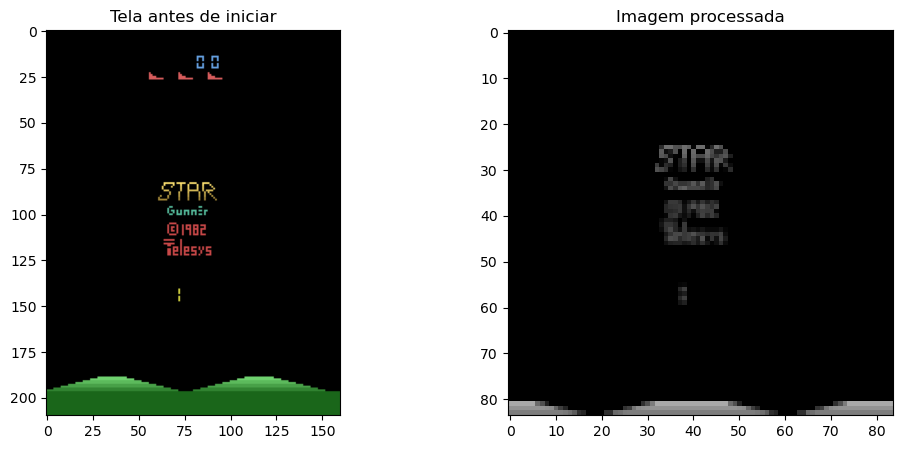

In [88]:
# Mostrando a tela do ambiente original, e outras telas após passar por alguns wrappers
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

s, _ = env2.reset()
ax1.imshow(s)
ax1.set_title('Tela antes de iniciar')

s, _ = env2d.reset()
ax2.imshow(s[0], cmap='gray', vmin=0, vmax=255)  # exibe em escala de cinza
ax2.set_title('Imagem processada');

In [89]:
# Para treinar o agente, rode o código abaixo
DQN_TRAIN(
    env = env2f,
    env_name = ATARI_ENV_NAME,
    gamma = GAMMA,
    qnet = qnet2,
    qnet_lr = LEARNING_RATE,
    target_qnet = qtarget2,
    target_update_freq = SYNC_TARGET_FRAMES,
    replay_size = REPLAY_SIZE,
    batch_size = BATCH_SIZE,
    epsilon_f = EPSILON_FINAL,
    epsilon_decay_period = EPSILON_DECAY_PERIOD,
    GOAL_REWARD = GOAL_REWARD,
    STEPS_STOP = STEPS_STOP)

275: finished 1 episodes, last reward 400.0, mean reward 400.000, eps 1.00, speed 723.49 steps/s
597: finished 2 episodes, last reward 300.0, mean reward 350.000, eps 1.00, speed 710.46 steps/s
903: finished 3 episodes, last reward 900.0, mean reward 533.333, eps 1.00, speed 750.93 steps/s
1042: finished 4 episodes, last reward 1100.0, mean reward 675.000, eps 1.00, speed 800.76 steps/s
1337: finished 5 episodes, last reward 700.0, mean reward 680.000, eps 1.00, speed 757.54 steps/s
1517: finished 6 episodes, last reward 600.0, mean reward 666.667, eps 1.00, speed 778.48 steps/s
1649: finished 7 episodes, last reward 400.0, mean reward 628.571, eps 1.00, speed 741.85 steps/s
2003: finished 8 episodes, last reward 500.0, mean reward 612.500, eps 0.99, speed 749.20 steps/s
2203: finished 9 episodes, last reward 500.0, mean reward 600.000, eps 0.99, speed 757.81 steps/s
2474: finished 10 episodes, last reward 400.0, mean reward 580.000, eps 0.99, speed 737.88 steps/s
2676: finished 11 epi

KeyboardInterrupt: 

In [ ]:
# Para carregar uma rede salva de arquivo, descomente o bloco abaixo
# Permite testar ou treinar mais
# filename = "/content/rl_facil/projeto/" if IN_COLAB else ""
# filename = filename + "BreakoutNoFrameskip-v4-2024-02-11,22-41-42.dat"
# qnet2.load_state_dict(torch.load(filename, map_location=lambda storage,loc: storage))

In [ ]:
# Roda alguns episódios com o modelo e salva os vídeos em arquivos
env2 = gym.make(ATARI_ENV_NAME, render_mode="rgb_array")
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, 4)
env2f = ScaledFloatFrame(env2e)

record_video_q_neuralnet(env2f, qnet2, episodes=1, folder="./dqn-StarGunner-v5")

c:\Users\augus\anaconda3\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\augus\OneDrive\Documentos\IA\RLProjectBreakout\dqn-StarGunner-v5 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\augus\anaconda3\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
c:\Users\augus\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\augus\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Moviepy - Building video c:\Users\augus\OneDrive\Documentos\IA\RLProjectBreakout\dqn-StarGunner-v5\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\augus\OneDrive\Documentos\IA\RLProjectBreakout\dqn-StarGunner-v5\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\augus\OneDrive\Documentos\IA\RLProjectBreakout\dqn-StarGunner-v5\rl-video-episode-0.mp4
Episode 0: 166 steps / return 600.00


In [ ]:
display_videos_from_path("./dqn-StarGunner-v5")

## PPO - Função principal

In [ ]:
ENV_NAME = 'StarGunnerNoFrameskip-v4'  
env = make_atari_env(ENV_NAME, n_envs=4, seed=0)
env = VecFrameStack(env, n_stack=4)
model = PPO(CnnPolicy, env, tensorboard_log="log_dir", verbose=1)

Using cuda device
Wrapping the env in a VecTransposeImage.


## PPO - Otimização de parâmetros + Treinamento

Otimização de 200 mil passos com as 27 possibilidades de parâmetros, alternando entre 3 valores de learning_rate, batch_size e n_steps

In [ ]:
model1 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=64,
    n_steps=2048,
)
model1.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.77e+03 |
|    ep_rew_mean     | 680      |
| time/              |          |
|    fps             | 633      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.01e+03    |
|    ep_rew_mean          | 729         |
| time/                   |             |
|    fps                  | 405         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.043527246 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss      

In [ ]:
model2 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=32,
    n_steps=2048,
)
model2.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.92e+03 |
|    ep_rew_mean     | 471      |
| time/              |          |
|    fps             | 646      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.21e+03   |
|    ep_rew_mean          | 562        |
| time/                   |            |
|    fps                  | 334        |
|    iterations           | 2          |
|    time_elapsed         | 48         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.05320282 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.88   

In [ ]:
model3 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=128,
    n_steps=2048,
)
model3.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.37e+03 |
|    ep_rew_mean     | 720      |
| time/              |          |
|    fps             | 464      |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.41e+03    |
|    ep_rew_mean          | 679         |
| time/                   |             |
|    fps                  | 400         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.021504521 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss      

In [ ]:
model4 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=64,
    n_steps=1024,
)
model4.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.57e+03 |
|    ep_rew_mean     | 1.22e+03 |
| time/              |          |
|    fps             | 556      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3.27e+03   |
|    ep_rew_mean          | 956        |
| time/                   |            |
|    fps                  | 354        |
|    iterations           | 2          |
|    time_elapsed         | 23         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.03176564 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.88   

In [ ]:
model5 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=64,
    n_steps=4096,
)
model5.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.3e+03  |
|    ep_rew_mean     | 920      |
| time/              |          |
|    fps             | 645      |
|    iterations      | 1        |
|    time_elapsed    | 25       |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.46e+03    |
|    ep_rew_mean          | 832         |
| time/                   |             |
|    fps                  | 405         |
|    iterations           | 2           |
|    time_elapsed         | 80          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.052437715 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss      

In [ ]:
model6 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=32,
    n_steps=1024,
)
model6.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.27e+03 |
|    ep_rew_mean     | 1.03e+03 |
| time/              |          |
|    fps             | 683      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 6.16e+03   |
|    ep_rew_mean          | 1.12e+03   |
| time/                   |            |
|    fps                  | 338        |
|    iterations           | 2          |
|    time_elapsed         | 24         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.05204335 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.88   

In [ ]:
model7 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=32,
    n_steps=4096,
)
model7.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.04e+03 |
|    ep_rew_mean     | 653      |
| time/              |          |
|    fps             | 519      |
|    iterations      | 1        |
|    time_elapsed    | 31       |
|    total_timesteps | 16384    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.23e+03   |
|    ep_rew_mean          | 703        |
| time/                   |            |
|    fps                  | 303        |
|    iterations           | 2          |
|    time_elapsed         | 107        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.07235366 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.87   

In [ ]:
model8 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=128,
    n_steps=1024,
)
model8.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.48e+03 |
|    ep_rew_mean     | 975      |
| time/              |          |
|    fps             | 560      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.54e+03    |
|    ep_rew_mean          | 822         |
| time/                   |             |
|    fps                  | 338         |
|    iterations           | 2           |
|    time_elapsed         | 24          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.018419676 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss      

In [ ]:
model9 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=128,
    n_steps=4096,
)
model9.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_9
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.31e+03 |
|    ep_rew_mean     | 743      |
| time/              |          |
|    fps             | 692      |
|    iterations      | 1        |
|    time_elapsed    | 23       |
|    total_timesteps | 16384    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.48e+03   |
|    ep_rew_mean          | 703        |
| time/                   |            |
|    fps                  | 472        |
|    iterations           | 2          |
|    time_elapsed         | 69         |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.02747101 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.88   

In [ ]:
model10 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=64,
    n_steps=2048,
)
model10.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_10
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.41e+03 |
|    ep_rew_mean     | 1.1e+03  |
| time/              |          |
|    fps             | 631      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.34e+03    |
|    ep_rew_mean          | 886         |
| time/                   |             |
|    fps                  | 404         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.010913707 |
|    clip_fraction        | 0.0748      |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model11 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=32,
    n_steps=2048,
)
model11.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.91e+03 |
|    ep_rew_mean     | 900      |
| time/              |          |
|    fps             | 677      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.97e+03    |
|    ep_rew_mean          | 853         |
| time/                   |             |
|    fps                  | 330         |
|    iterations           | 2           |
|    time_elapsed         | 49          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012761388 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model12 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=128,
    n_steps=2048,
)
model12.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_12
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.13e+03 |
|    ep_rew_mean     | 862      |
| time/              |          |
|    fps             | 378      |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4.76e+03     |
|    ep_rew_mean          | 780          |
| time/                   |              |
|    fps                  | 299          |
|    iterations           | 2            |
|    time_elapsed         | 54           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0079221865 |
|    clip_fraction        | 0.06         |
|    clip_range           | 0.2          |
|    entr

In [ ]:
model13 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=64,
    n_steps=1024,
)
model13.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_13
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.05e+03 |
|    ep_rew_mean     | 900      |
| time/              |          |
|    fps             | 515      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.04e+03    |
|    ep_rew_mean          | 914         |
| time/                   |             |
|    fps                  | 332         |
|    iterations           | 2           |
|    time_elapsed         | 24          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008581622 |
|    clip_fraction        | 0.0668      |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model14 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="ofirst_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=64,
    n_steps=4096,
)
model14.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ofirst_optimize\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.04e+03 |
|    ep_rew_mean     | 620      |
| time/              |          |
|    fps             | 372      |
|    iterations      | 1        |
|    time_elapsed    | 43       |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.12e+03    |
|    ep_rew_mean          | 677         |
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 2           |
|    time_elapsed         | 125         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.011650529 |
|    clip_fraction        | 0.0825      |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model15 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=32,
    n_steps=1024,
)
model15.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_14
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.91e+03 |
|    ep_rew_mean     | 733      |
| time/              |          |
|    fps             | 682      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.53e+03    |
|    ep_rew_mean          | 767         |
| time/                   |             |
|    fps                  | 319         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.011568998 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model16 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=32,
    n_steps=4096,
)
model16.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_15
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.42e+03 |
|    ep_rew_mean     | 612      |
| time/              |          |
|    fps             | 381      |
|    iterations      | 1        |
|    time_elapsed    | 42       |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.64e+03    |
|    ep_rew_mean          | 676         |
| time/                   |             |
|    fps                  | 243         |
|    iterations           | 2           |
|    time_elapsed         | 134         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.015791748 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model17 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=128,
    n_steps=1024,
)
model17.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_16
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.4e+03  |
|    ep_rew_mean     | 1.93e+03 |
| time/              |          |
|    fps             | 798      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 5.43e+03     |
|    ep_rew_mean          | 1.33e+03     |
| time/                   |              |
|    fps                  | 548          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0073201247 |
|    clip_fraction        | 0.0331       |
|    clip_range           | 0.2          |
|    entr

In [ ]:
model18 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=128,
    n_steps=4096,
)
model18.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_17
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.01e+03 |
|    ep_rew_mean     | 620      |
| time/              |          |
|    fps             | 741      |
|    iterations      | 1        |
|    time_elapsed    | 22       |
|    total_timesteps | 16384    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.08e+03   |
|    ep_rew_mean          | 681        |
| time/                   |            |
|    fps                  | 510        |
|    iterations           | 2          |
|    time_elapsed         | 64         |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.00915719 |
|    clip_fraction        | 0.0463     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.89  

In [ ]:
model19 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=64,
    n_steps=2048,
)
model19.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_18
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.04e+03 |
|    ep_rew_mean     | 712      |
| time/              |          |
|    fps             | 829      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.85e+03    |
|    ep_rew_mean          | 582         |
| time/                   |             |
|    fps                  | 477         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.091922864 |
|    clip_fraction        | 0.31        |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model20 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=64,
    n_steps=1024,
)
model20.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_19
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.82e+03 |
|    ep_rew_mean     | 800      |
| time/              |          |
|    fps             | 812      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.92e+03    |
|    ep_rew_mean          | 667         |
| time/                   |             |
|    fps                  | 484         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.067213744 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model21 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=64,
    n_steps=4096,
)
model21.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_20
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.28e+03 |
|    ep_rew_mean     | 850      |
| time/              |          |
|    fps             | 754      |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 16384    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.62e+03   |
|    ep_rew_mean          | 828        |
| time/                   |            |
|    fps                  | 450        |
|    iterations           | 2          |
|    time_elapsed         | 72         |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.09881404 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.86  

In [ ]:
model22 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=32,
    n_steps=2048,
)
model22.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_21
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.15e+03 |
|    ep_rew_mean     | 967      |
| time/              |          |
|    fps             | 837      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.4e+03    |
|    ep_rew_mean          | 923        |
| time/                   |            |
|    fps                  | 382        |
|    iterations           | 2          |
|    time_elapsed         | 42         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.14220835 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.85  

In [ ]:
model23 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=32,
    n_steps=1024,
)
model23.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_22
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.05e+03 |
|    ep_rew_mean     | 933      |
| time/              |          |
|    fps             | 830      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.81e+03    |
|    ep_rew_mean          | 800         |
| time/                   |             |
|    fps                  | 378         |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.094562516 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model24 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=32,
    n_steps=4096,
)
model24.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_23
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.04e+03 |
|    ep_rew_mean     | 638      |
| time/              |          |
|    fps             | 751      |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.24e+03    |
|    ep_rew_mean          | 774         |
| time/                   |             |
|    fps                  | 357         |
|    iterations           | 2           |
|    time_elapsed         | 91          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.121751346 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model25 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=128,
    n_steps=2048,
)
model25.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_24
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.72e+03 |
|    ep_rew_mean     | 838      |
| time/              |          |
|    fps             | 839      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.06e+03    |
|    ep_rew_mean          | 806         |
| time/                   |             |
|    fps                  | 551         |
|    iterations           | 2           |
|    time_elapsed         | 29          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.053800173 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss     

In [ ]:
model26 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="first_optimize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=128,
    n_steps=1024,
)
model26.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_25
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.43e+03 |
|    ep_rew_mean     | 700      |
| time/              |          |
|    fps             | 558      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.93e+03    |
|    ep_rew_mean          | 700         |
| time/                   |             |
|    fps                  | 409         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.032284062 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss     

_______________________________________________________________________________________

Otimização de 400 mil passos com as 6 melhores combinações de parâmetros da primeira otimização

In [ ]:
model1 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="second_optmize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=64,
    n_steps=1024,
)

model1.learn(total_timesteps=400_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to second_optmize\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.8e+03  |
|    ep_rew_mean     | 567      |
| time/              |          |
|    fps             | 626      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.52e+03    |
|    ep_rew_mean          | 620         |
| time/                   |             |
|    fps                  | 434         |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.033196338 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss      

In [ ]:
model2 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="second_optmize",
    verbose=1,
    learning_rate=0.0003,
    batch_size=32,
    n_steps=2048,
)

model2.learn(total_timesteps=400_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to second_optmize\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.7e+03  |
|    ep_rew_mean     | 762      |
| time/              |          |
|    fps             | 643      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.43e+03    |
|    ep_rew_mean          | 671         |
| time/                   |             |
|    fps                  | 306         |
|    iterations           | 2           |
|    time_elapsed         | 53          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.062491897 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss      

In [ ]:
model3 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="second_optmize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=64,
    n_steps=4096,
)

model13.learn(total_timesteps=400_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to first_optimize\PPO_27
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.9e+03  |
|    ep_rew_mean     | 1.08e+03 |
| time/              |          |
|    fps             | 799      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 3.18e+03  |
|    ep_rew_mean          | 1.06e+03  |
| time/                   |           |
|    fps                  | 476       |
|    iterations           | 2         |
|    time_elapsed         | 17        |
|    total_timesteps      | 8192      |
| train/                  |           |
|    approx_kl            | 0.2255277 |
|    clip_fraction        | 0.55      |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.32     |
|    exp

In [ ]:
model4 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="second_optmize",
    verbose=1,
    learning_rate=0.0001,
    batch_size=128,
    n_steps=1024,
)

model4.learn(total_timesteps=400_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to second_optmize\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.17e+03 |
|    ep_rew_mean     | 1.12e+03 |
| time/              |          |
|    fps             | 814      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.58e+03   |
|    ep_rew_mean          | 962        |
| time/                   |            |
|    fps                  | 547        |
|    iterations           | 2          |
|    time_elapsed         | 14         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01146072 |
|    clip_fraction        | 0.0593     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.88   

In [ ]:
model5 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="second_optmize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=32,
    n_steps=2048,
)

model5.learn(total_timesteps=400_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to second_optmize\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.38e+03 |
|    ep_rew_mean     | 667      |
| time/              |          |
|    fps             | 774      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3.44e+03   |
|    ep_rew_mean          | 637        |
| time/                   |            |
|    fps                  | 364        |
|    iterations           | 2          |
|    time_elapsed         | 44         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.11223486 |
|    clip_fraction        | 0.364      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.86   

In [ ]:
model6 = PPO(
    CnnPolicy,
    env,
    tensorboard_log="second_optmize",
    verbose=1,
    learning_rate=0.0005,
    batch_size=64,
    n_steps=1024,
)

model6.learn(total_timesteps=400_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to second_optmize\PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.65e+03 |
|    ep_rew_mean     | 1.45e+03 |
| time/              |          |
|    fps             | 814      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.62e+03    |
|    ep_rew_mean          | 1.19e+03    |
| time/                   |             |
|    fps                  | 474         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.074629635 |
|    clip_fraction        | 0.314       |
|    clip_range           | 0.2         |
|    entropy_loss      

____________________

Treinamento por 1M de passos com a melhor combinação de parâmetros

In [ ]:
model = PPO(CnnPolicy, env, tensorboard_log="ppo_run", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=2048)
model.learn(total_timesteps=1_000_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ppo_run\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.67e+03 |
|    ep_rew_mean     | 725      |
| time/              |          |
|    fps             | 762      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4.02e+03     |
|    ep_rew_mean          | 775          |
| time/                   |              |
|    fps                  | 364          |
|    iterations           | 2            |
|    time_elapsed         | 44           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0137526225 |
|    clip_fraction        | 0.0958       |
|    clip_range           | 0.2          |
|    entropy_loss

In [ ]:
model = PPO(CnnPolicy, env, tensorboard_log="ppo_run", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=2048)
model.learn(total_timesteps=1_000_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ppo_run\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.02e+03 |
|    ep_rew_mean     | 867      |
| time/              |          |
|    fps             | 817      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.27e+03    |
|    ep_rew_mean          | 775         |
| time/                   |             |
|    fps                  | 376         |
|    iterations           | 2           |
|    time_elapsed         | 43          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012538863 |
|    clip_fraction        | 0.078       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2

In [ ]:
model = PPO(CnnPolicy, env, tensorboard_log="ppo_run", verbose=1,learning_rate=0.0001,batch_size=32,n_steps=2048)
model.learn(total_timesteps=1_000_000)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ppo_run\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.92e+03 |
|    ep_rew_mean     | 717      |
| time/              |          |
|    fps             | 820      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.07e+03   |
|    ep_rew_mean          | 673        |
| time/                   |            |
|    fps                  | 373        |
|    iterations           | 2          |
|    time_elapsed         | 43         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01202154 |
|    clip_fraction        | 0.0913     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.88      |
| 

## PPO - Resultados

In [ ]:
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)

print(f"Retorno médio: {mean_reward:.2f} +/- {std_reward:.2f}")

Retorno médio: 1414.00 +/- 236.65


In [ ]:
# model.learn(total_timesteps=100_000)

In [ ]:
model.save("ppo_model")
# del model  # delete trained model from memory to demonstrate loading

In [ ]:
# model = PPO.load("ppo_model")

In [ ]:
# model.set_env(gym.make(ENV_NAME))
# model.learn(total_timesteps=100_000)

In [ ]:
# # Evaluate the trained agent
# mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=30)

# print(f"Retorno médio: {mean_reward:.2f} +/- {std_reward:.2f}")

## Gráficos de comparação + Tensorboard

In [92]:
import os

# Check current working directory
print("Current working directory:", os.getcwd())

# Example of using an absolute path
# Replace 'absolute/path/to/first_optimize' with the actual absolute path
log_directory = "c:\Users\augus\OneDrive\Documentos\IA\RLProjectBreakout\first_optimize"

# Check if the directory exists
if os.path.isdir(log_directory):
    print("Directory exists.")
else:
    print("Directory does not exist.")

Current working directory: c:\Users\augus\OneDrive\Documentos\IA\RLProjectBreakout
Directory does not exist.


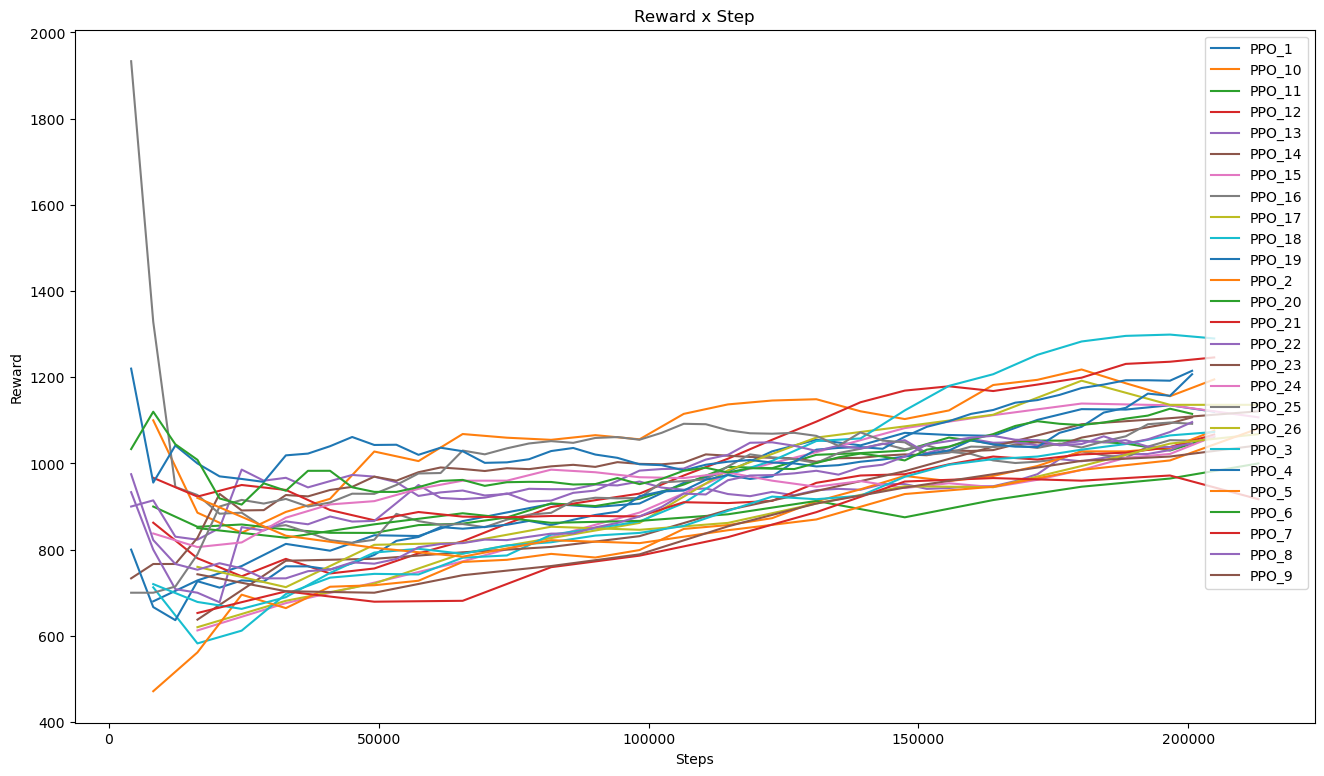

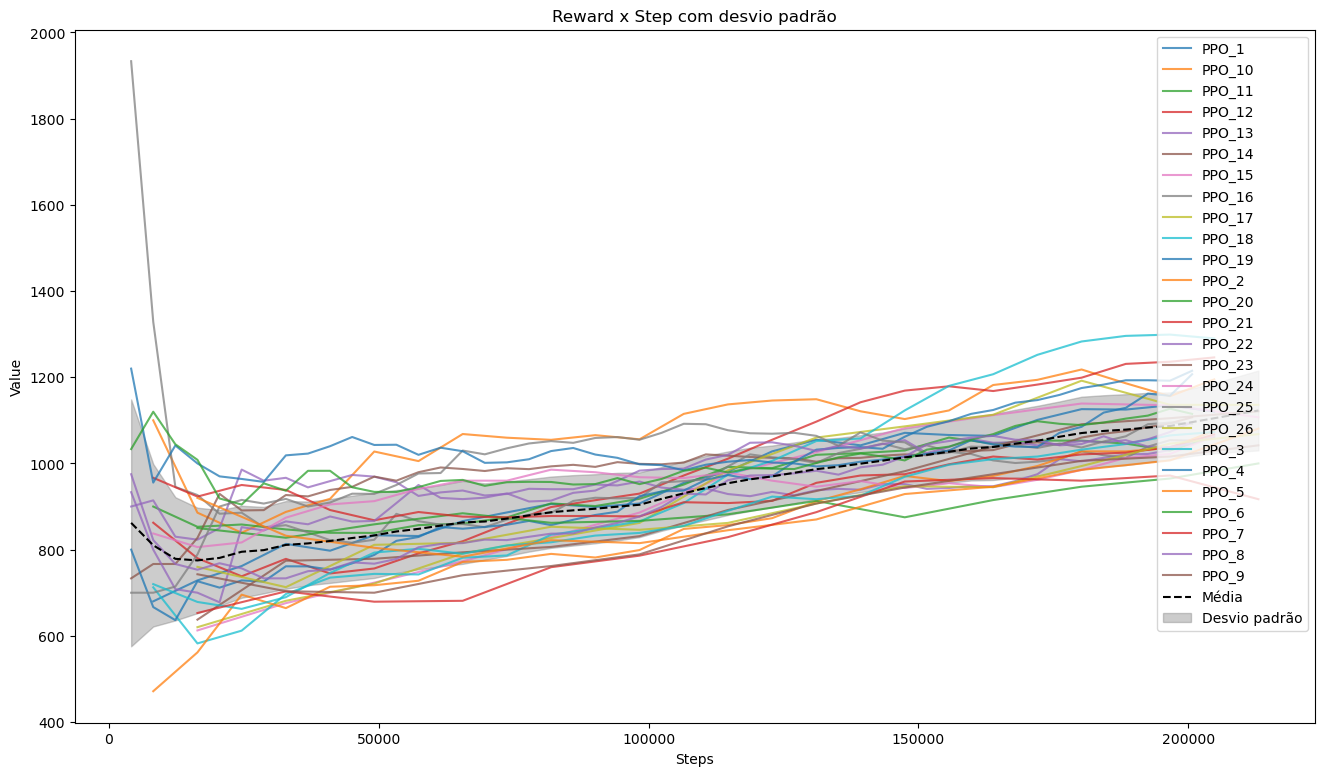

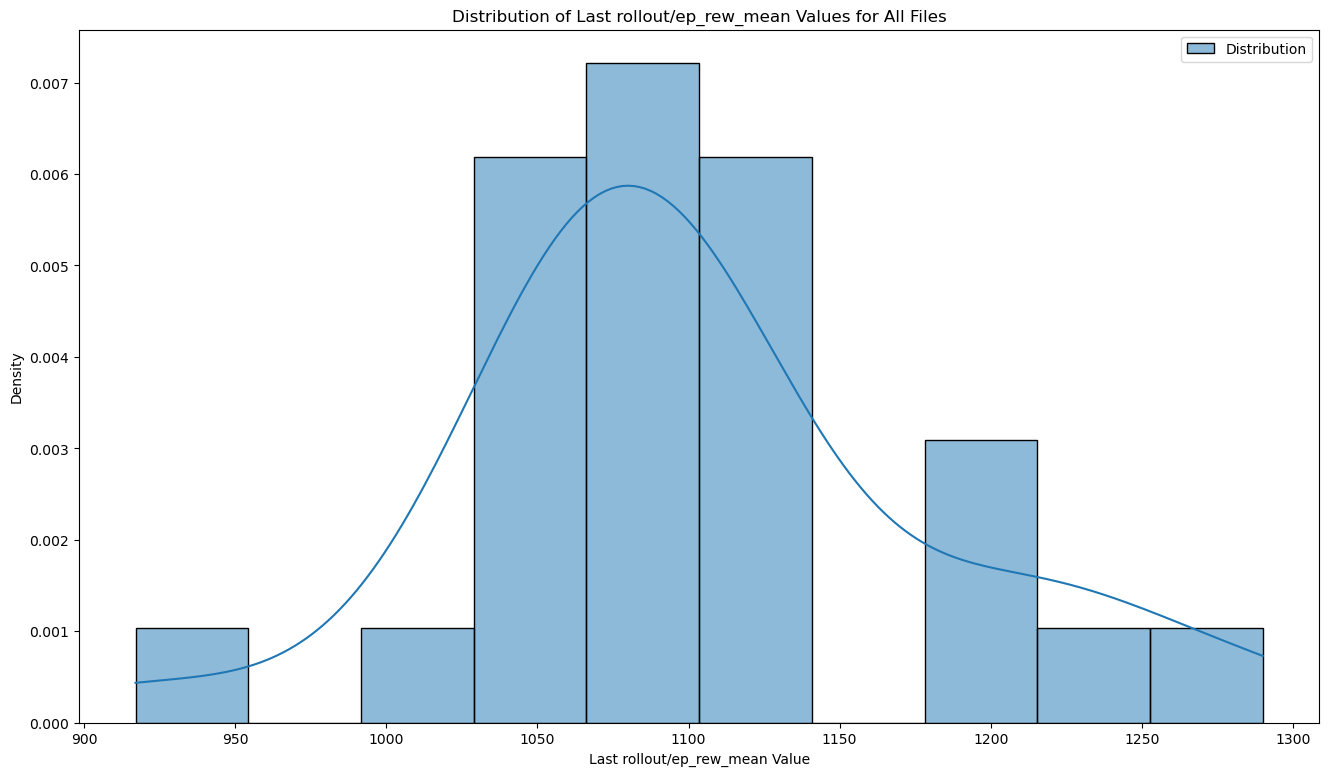

In [16]:
plot_individual(["./first_optimize/"])
plot_individual_and_mean_with_std_and_distribution("./first_optimize/")
plot_distribution_of_last_values("./first_optimize/")

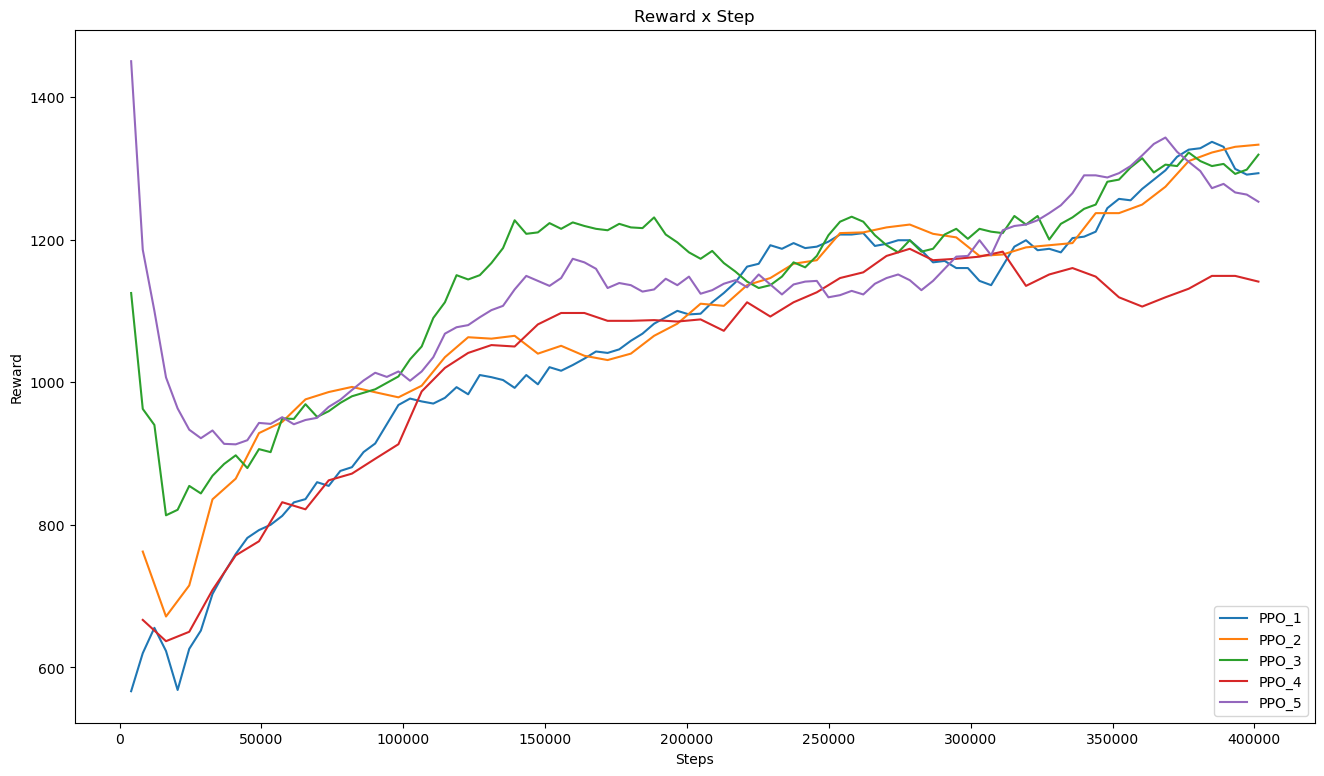

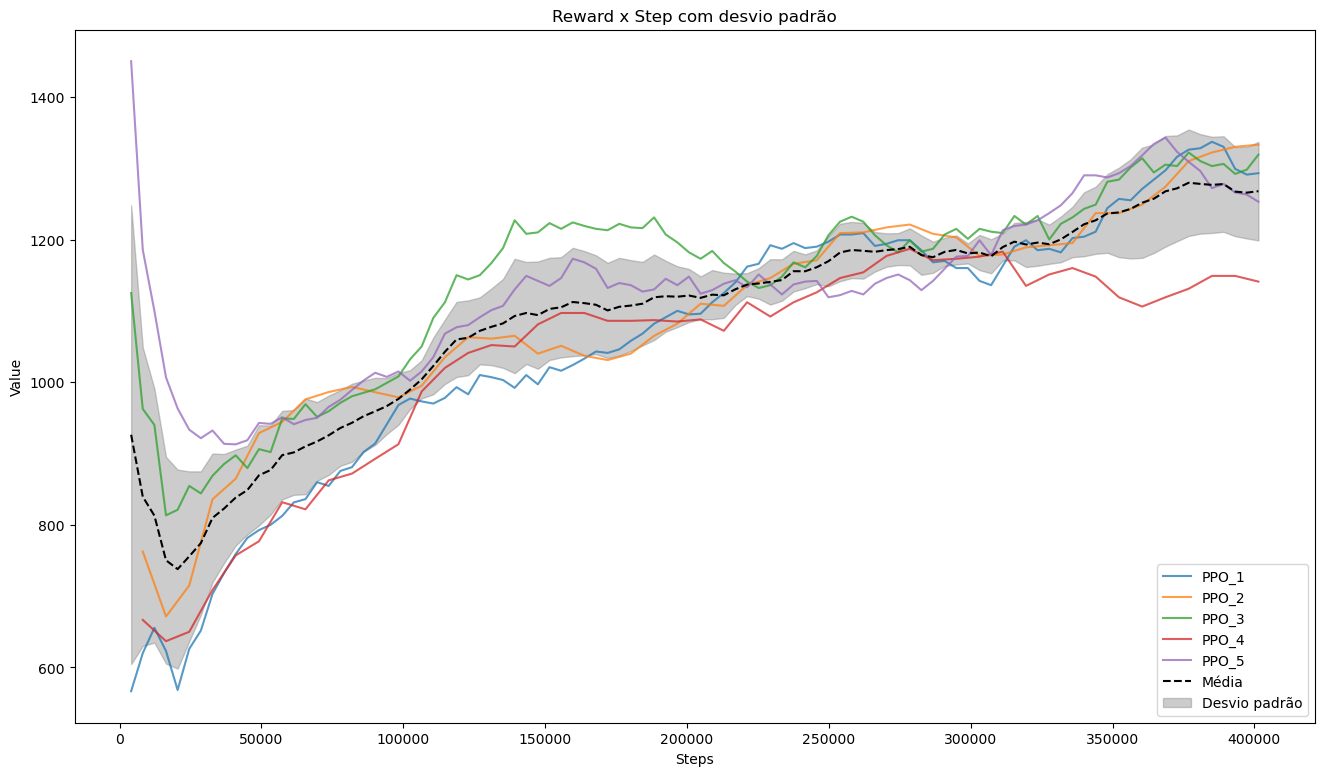

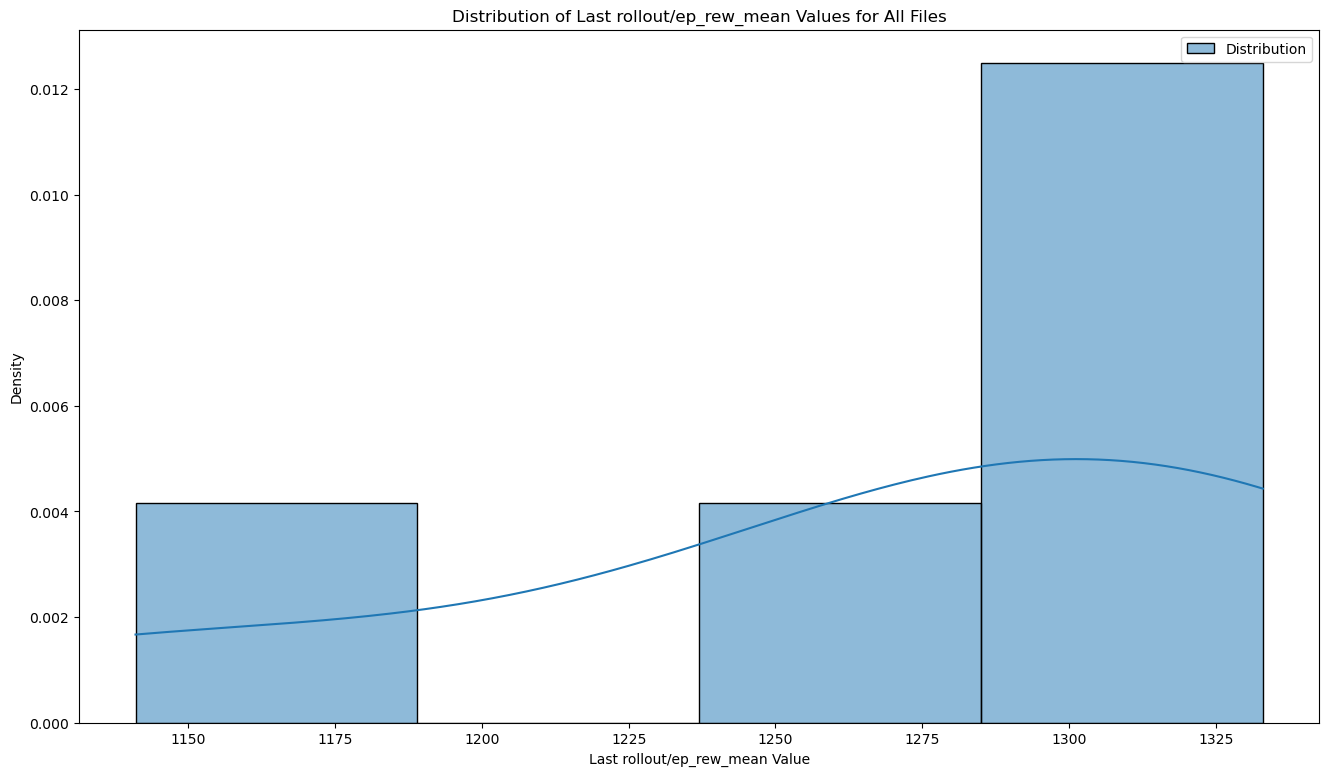

In [96]:
plot_individual(['./second_optmize/'])
plot_individual_and_mean_with_std_and_distribution("./second_optmize/")
plot_distribution_of_last_values("./second_optmize/")

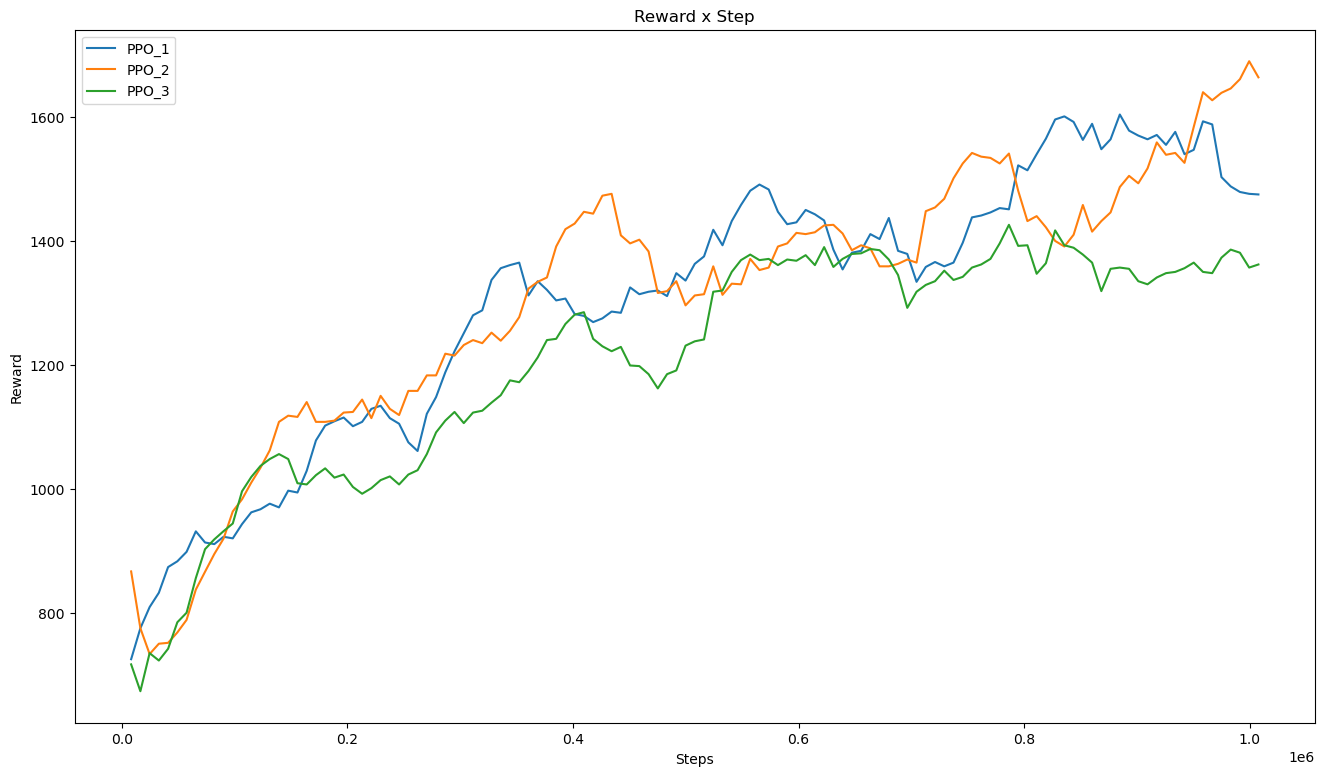

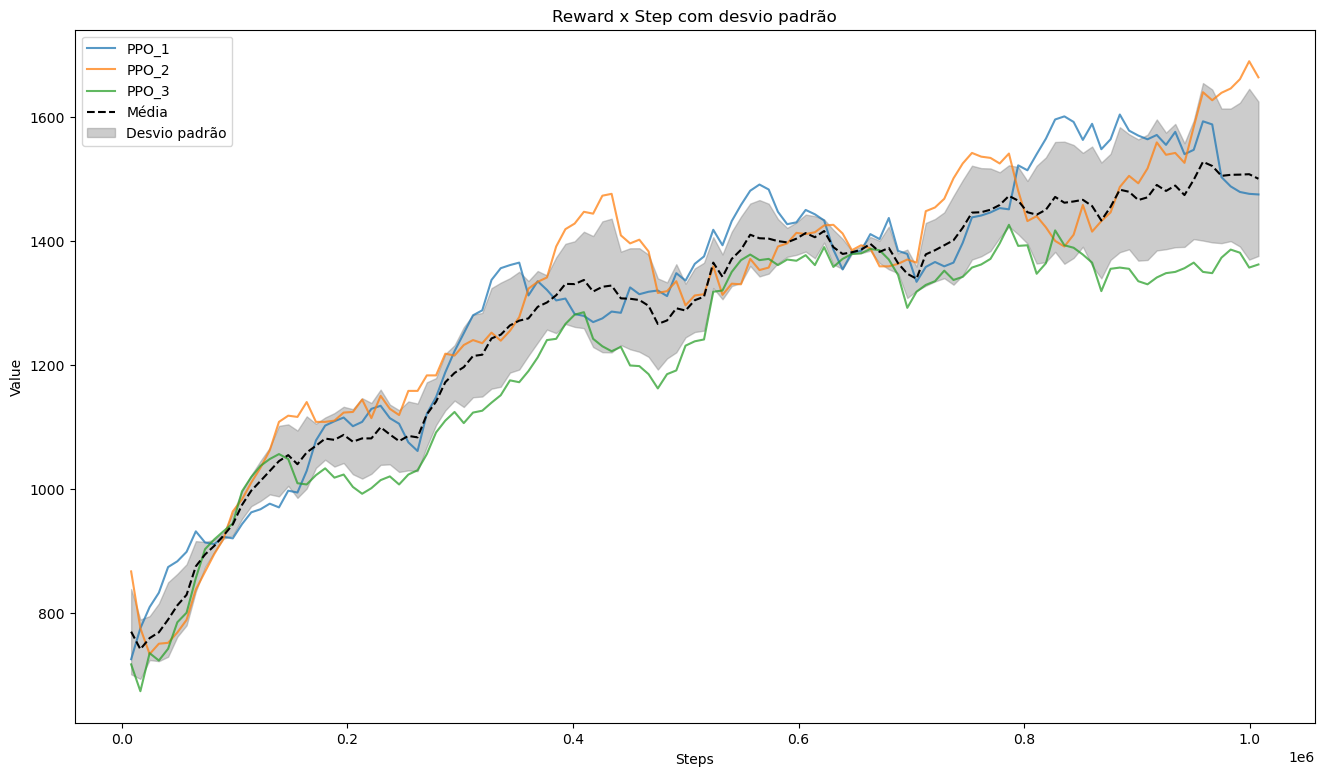

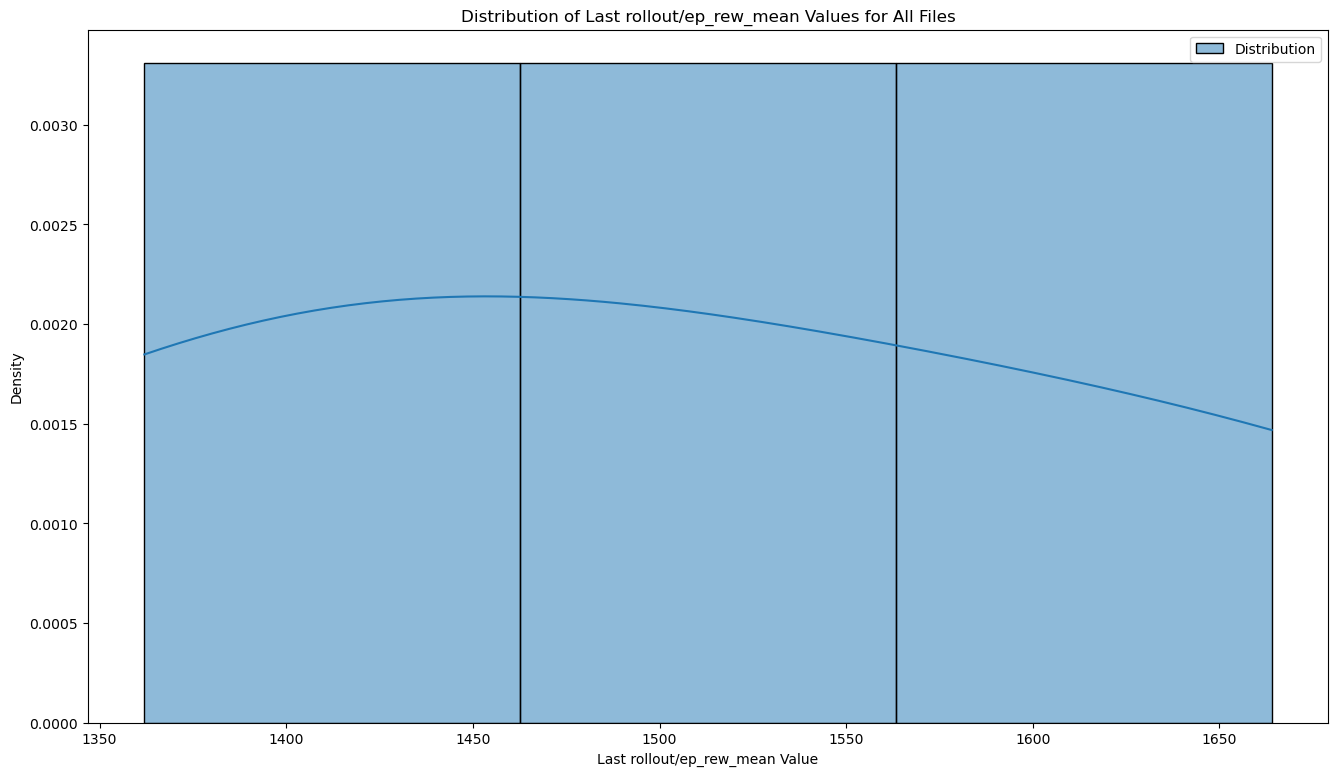

In [97]:
plot_individual(['./ppo_run/'])
plot_individual_and_mean_with_std_and_distribution('./ppo_run/')
plot_distribution_of_last_values('./ppo_run/')

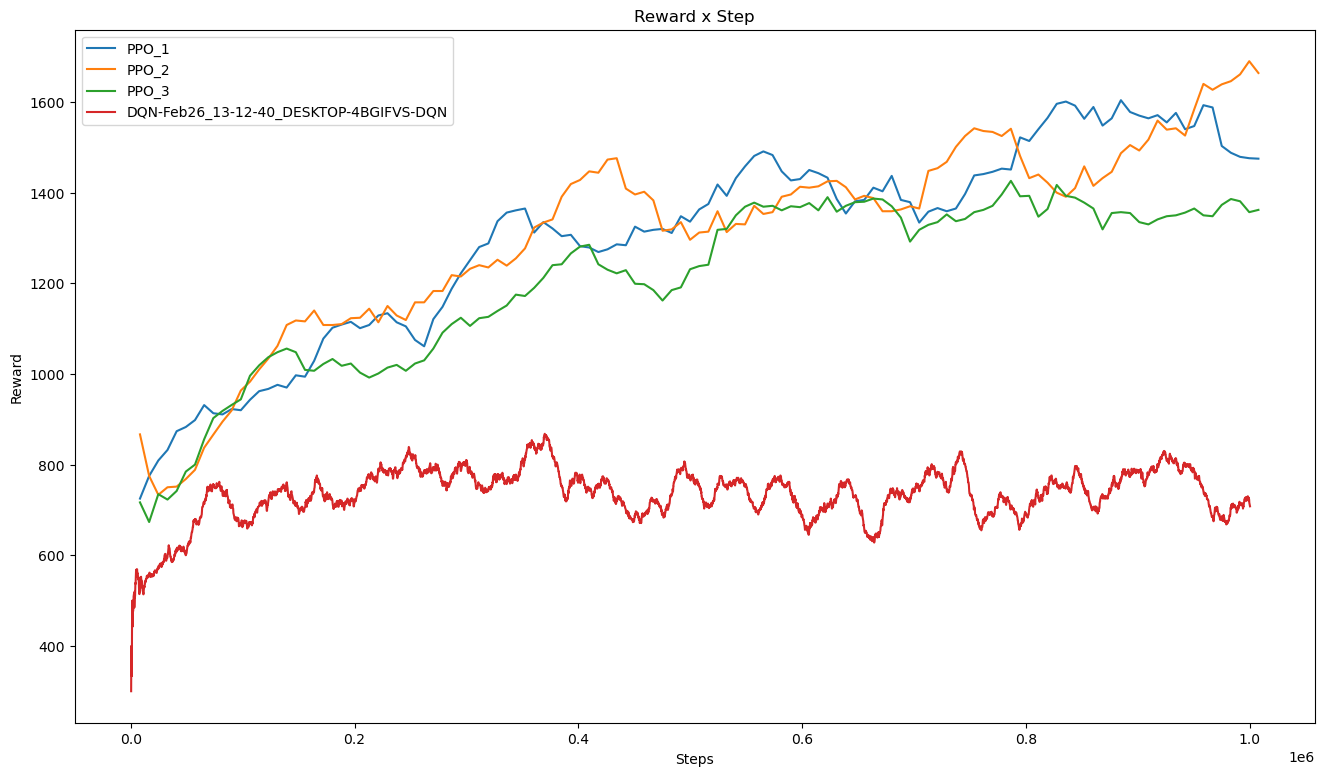

In [17]:
log_directories = ['./ppo_run/', './runs/']
plot_individual(log_directories)

In [99]:
%tensorboard runs:ppo_run

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-02-27 10:28:37.854107: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: argument {serve,dev}: invalid choice: 'runs:ppo_run' (choose from 'serve', 'dev')